<a href="https://colab.research.google.com/github/machiwao/CCMACLRL_PROJECT_COM222/blob/main/project_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Shopee Computer Product Reviews

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

In [2]:
df = pd.read_csv("hf://datasets/magixxixx/shopee-product-reviews-on-computer-category/combined-dataset-shuffled-cased-40K.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df.head()

,text,sentiment
0,mali yung dineliver 2l order ko naging 1l bulok!,0
1,xl order ko dumating large.nkalagay sa sticker...,0
2,"sobrang bilis ma lowbat, hindi masyado nakaka ...",0
3,first time ko umorder dito. di naman gumagana ...,0
4,"not well packed, wala itong box. hindi sya ma ...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
df.isnull().sum()

,0
text,0
sentiment,0


In [6]:
df.duplicated().sum()

1

In [7]:
df['sentiment'].value_counts()

,count
sentiment,
0,20000
1,20000


## Data Preprocessing

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
# remove stopwords
filipino_stopwords = set([
      'akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano',
      'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago',
      'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito',
      'doon', 'eh', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang',
      'gumawa', 'gusto', 'ha', 'habang', 'hanggang', 'hindi', 'huwag', 'hoy',
      'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan',
      'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyang','iyong', 'ka',
      'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang',
      'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan',
      'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang',
      'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari',
      'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat',
      'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na',
      'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'nang',
      'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ngunit', 'ni', 'nila', 'nilang',
      'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa',
      'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'pala', 'palabas',
      'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho',
      'pataas', 'pero', 'po', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi',
      'sabihin', 'sarili', 'sila', 'sino', 'siya',
      'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'yan', 'yung', 'username'
  ])
english_stopwords = set(stopwords.words('english'))
combined_stopwords = filipino_stopwords.union(english_stopwords)

In [10]:
def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  # remove_digits_urls_special_chars
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\s+$', '', text)
  text = re.sub(r'\d+', '', text)

  text = ' '.join([word for word in text.split() if word not in combined_stopwords])

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [11]:
df['text'] = df['text'].apply(preprocess_text)

## Training the Model

In [12]:
X = df['text']
y = df['sentiment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
combined_stopwords_list = list(combined_stopwords)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5, stop_words=combined_stopwords_list)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [21]:
from sklearn.svm import SVC

model = SVC()

## Hyperparameter Tuning and Cross Validation

In [24]:
param_grid = {
    'C': [0.1, 1, 5, 10, 100],
    'kernel': ['linear'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale','auto']
}

In [ ]:
grid = GridSearchCV(model, param_grid, refit=True, cv=5, return_train_score=True, verbose=0)

# Train with grid search
grid.fit(X_train_transformed, y_train)

# Access cv_results_ to extract scores
cv_results = grid.cv_results_

# Iterate over all combinations of parameters
for i in range(len(cv_results['params'])):
    print(f"Iteration {i+1}:")
    print(f"Parameters: {cv_results['params'][i]}")

    # Train accuracy for this iteration
    train_acc = cv_results['mean_train_score'][i]
    print(f"Train Accuracy: {train_acc:.4f}")

    # Test accuracy for this iteration (mean cross-validated test score)
    test_acc = cv_results['mean_test_score'][i]
    print(f"Test Accuracy: {test_acc:.4f}")
    print('-' * 50)

In [ ]:
# Best parameters
print("Best Parameters: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

In [25]:
# Chosen Model
model = SVC(C = 1, gamma = 1, kernel = 'linear')
model.fit(X_train_transformed, y_train)

SVC(C=1, gamma=1, kernel='linear')

In [29]:
# Cross Validation
X_transformed = vectorizer.transform(X)
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(cv_scores)
print(cv_scores.mean())
print(cv_scores.std())

[0.970125   0.970125   0.966      0.971      0.96837105]
0.9691242092761595
0.0017804321348306171


## Model Testing

In [30]:
y_pred = model.predict(X_test_transformed)
final_test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy of Best Model: {final_test_acc:.4f}")


Final Test Accuracy of Best Model: 0.9698


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3968
           1       0.97      0.97      0.97      4032

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



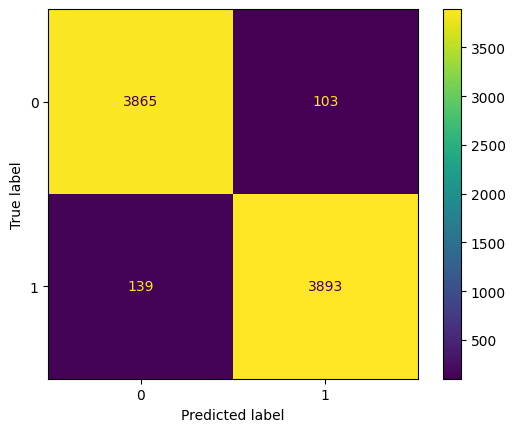

In [32]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [34]:
input_texts = ['This shit is so damn good product',
               'Hindi niyo ako maloloko! Original to noh? Ang ganda!',
               'Tangina good shit!', 'Tagal niya dumating pero ang solid hahaha',
               'Ito na yon? Hindi man lang tumagal.', 'Anggggg gandaaaaaa.',
               'Angggggggg lupittttttt sulitttttt baaaaayaaaaaadd tttttaaaaaeeeeeenaaaaa!',
               'Tangina ang tagal ko itong hinintay ka-excite gamitin maganda raw eh hehe']

In [33]:
input_text = pd.Series("Ang bilis ng delivery kaso pagdating sakin di naman gumagana, solid")
input_text = input_text.apply(preprocess_text)
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)

array([1])

In [ ]:
for text in input_texts:
  input_text = pd.Series(text)
  input_text = input_text.apply(preprocess_text)
  input_text_transform = vectorizer.transform(input_text)
  prediction = model.predict(input_text_transform)
  print(f"")